### Image Classification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange

#### CIFAR-10

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=True,
    download=True,
    transform=transform
)

valset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=16,
    shuffle=True,
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset.data.shape

(50000, 32, 32, 3)

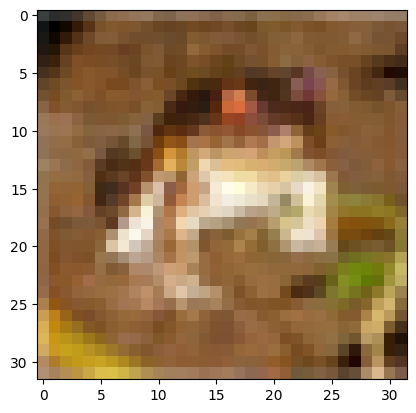

In [6]:
plt.imshow(trainset.data[0, :, :, :])

In [7]:
def plot_image(image, one_channel=False):
    if one_channel:
        image = image.mean(dim=0)
    image = image / 2 + 0.5
    np_image = image.numpy()
    if one_channel:
        plt.imshow(np_image, cmap="Greys")
    else:
        plt.imshow(np.transpose(np_image, (1, 2, 0)))

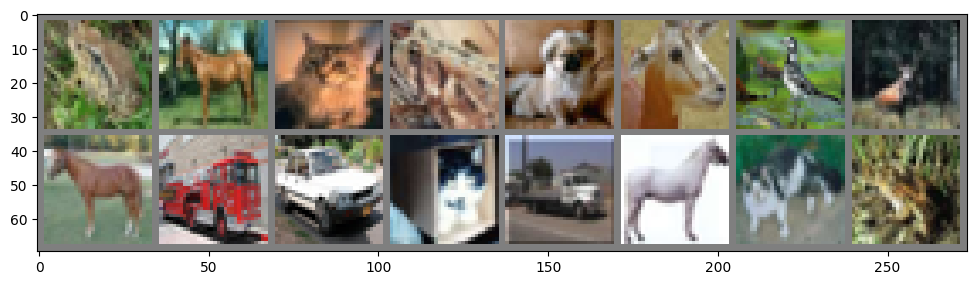

In [8]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(12,12))
image_grid = torchvision.utils.make_grid(images)
plot_image(image_grid, one_channel=False)

In [9]:
def plot_history(train_history, val_history, title='Loss'):
    plt.figure()
    plt.title(f"{title}")
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel("Train steps")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

В качестве бейзлайна берем сверточную сеть, состоящую из 1 VGG блока

In [10]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch_size, n_channels, height, width)
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x      

In [11]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for images, labels in tqdm(train_dataloader, desc=f'Training, epoch № {epoch}', leave=False):
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits,
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])

        # Validation
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc=f'Validatin, epoch № {epoch}', leave=False):
                 y_pred = model(images)
            loss = criterion(y_pred, labels)
            val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            val_epoch_true_hits = torch.cat((
                val_epoch_true_hits,
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")
        print("Train loss:", train_epoch_loss.mean().item())
        print("Train acc:", (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item())
        print("Val loss:", val_epoch_loss.mean().item())
        print("Val acc:", (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item())

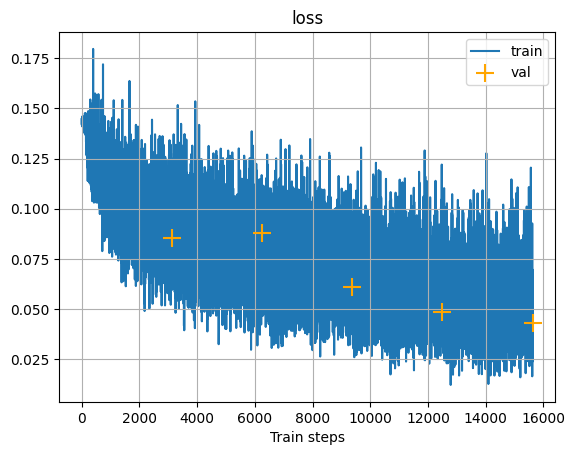

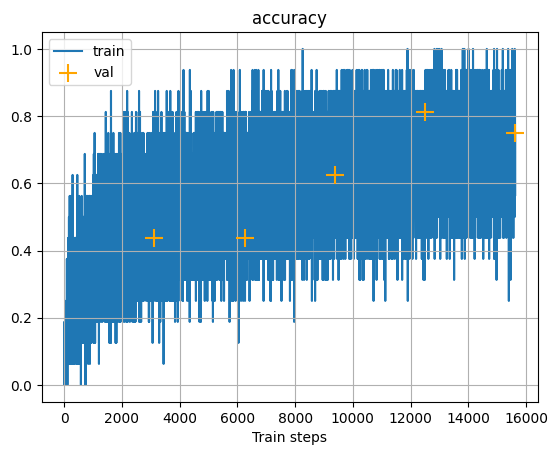

Train loss: 0.05400504544377327
Train acc: 0.6942800283432007
Val loss: 0.04328271374106407
Val acc: 0.75


In [12]:
model_baseline = ModelBaseline()
optimizer = torch.optim.SGD(model_baseline.parameters(), lr=0.01)
critetion = nn.CrossEntropyLoss()

train(model_baseline, critetion, optimizer, train_dataloader, val_dataloader)

### Visualizing parameters

In [13]:
from filter_vz import plot_filters

In [14]:
model_baseline

ModelBaseline(
  (vgg): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [15]:
model_baseline.vgg[0]

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)

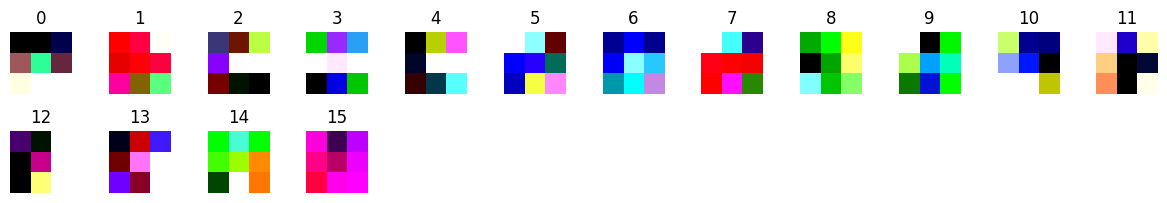

In [16]:
model_baseline.cpu()
plot_filters(model_baseline.vgg[0], single_channel=False)

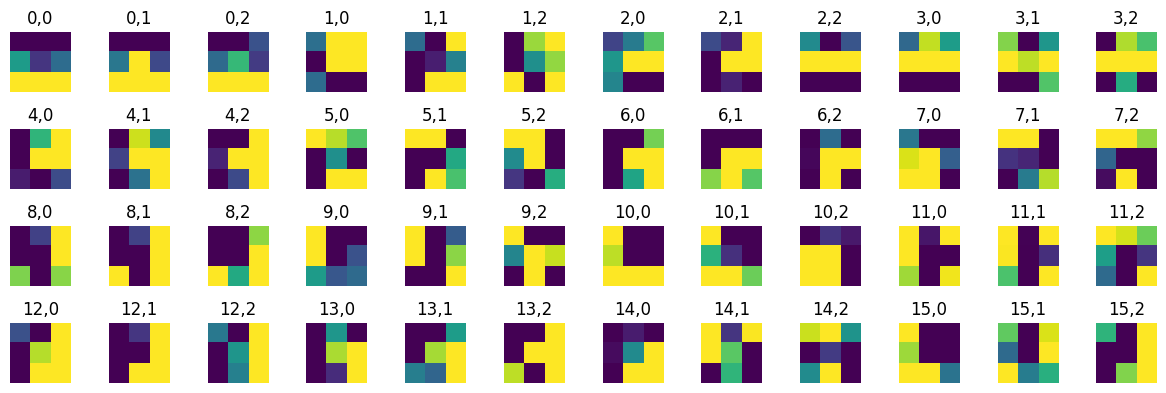

In [17]:
plot_filters(model_baseline.vgg[0], single_channel=True)

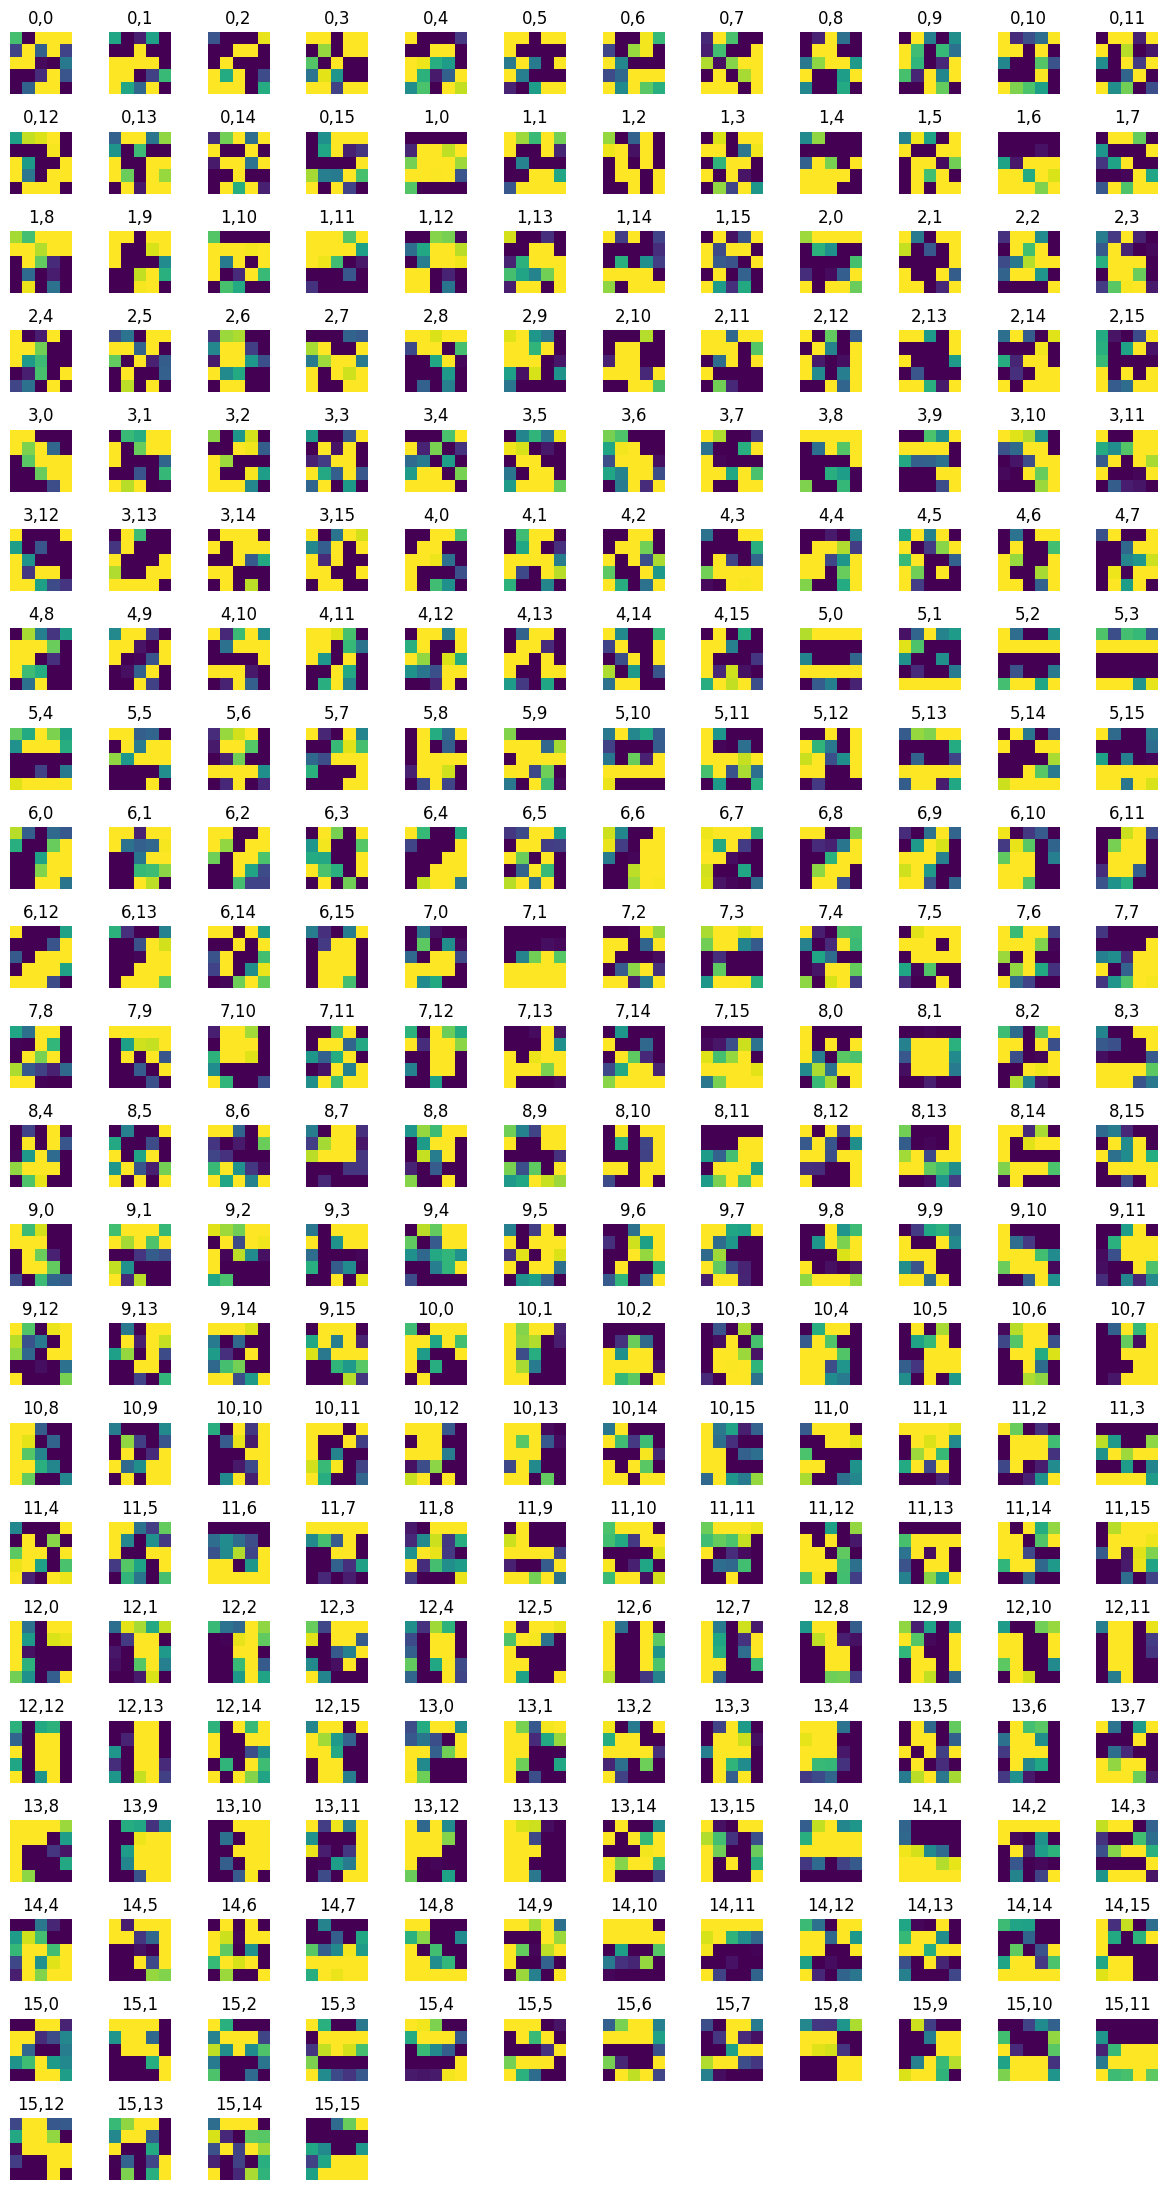

In [19]:
plot_filters(model_baseline.vgg[2], single_channel=True)

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch_size, n_channels, height, width)
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x      

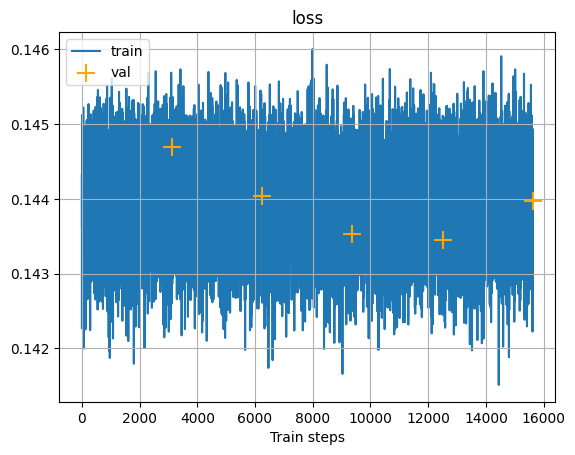

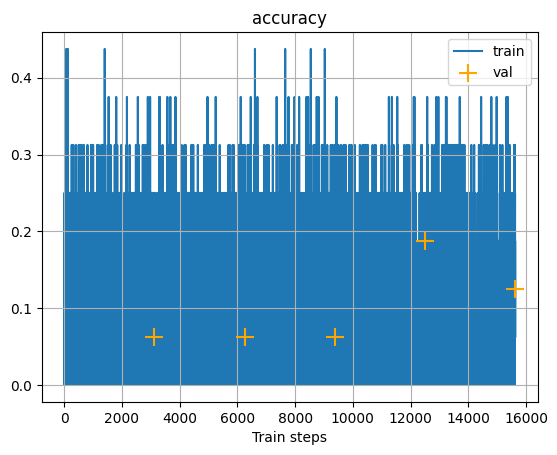

Train loss: 0.14396941661834717
Train acc: 0.10010000318288803
Val loss: 0.14397813379764557
Val acc: 0.125


In [21]:
my_model = MyModel()
optimizer = torch.optim.SGD(model_baseline.parameters(), lr=0.01)
critetion = nn.CrossEntropyLoss()

train(my_model, critetion, optimizer, train_dataloader, val_dataloader)

### Augmentation

In [24]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=True,
    download=True,
    transform=transform
)

valset = torchvision.datasets.CIFAR10(
    root='./cifar',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=16,
    shuffle=True,
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


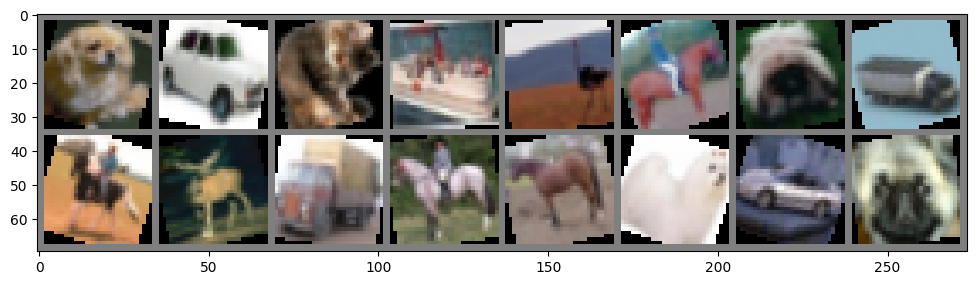

In [25]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(12,12))
img_grid = torchvision.utils.make_grid(images)
plot_image(img_grid, one_channel=False)

### Dropout, Batch Normalization

In [26]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout2d(0, 2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)
)

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

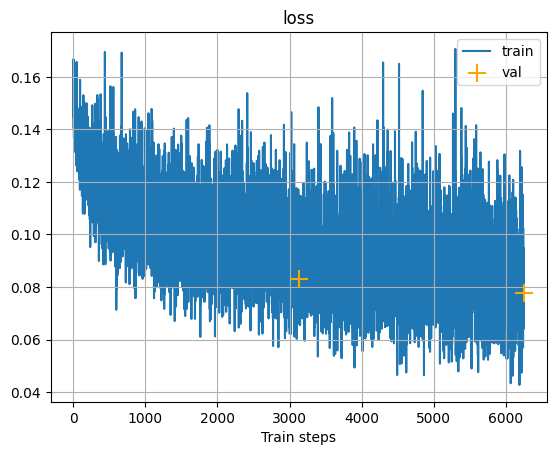

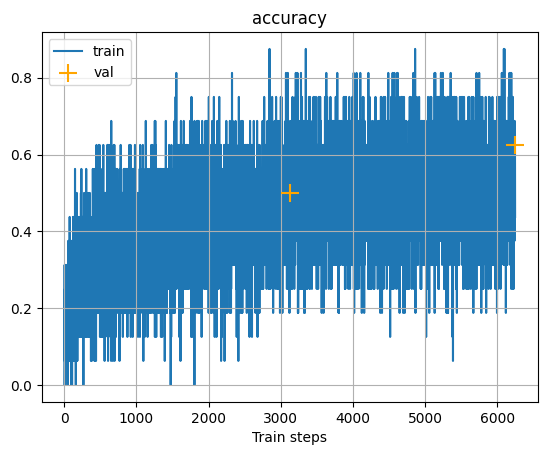

Train loss: 0.0878816768527031
Train acc: 0.49702000617980957
Val loss: 0.07776424288749695
Val acc: 0.625


Training, epoch № 2:   0%|          | 0/3125 [00:04<?, ?it/s]

Validatin, epoch № 2:   0%|          | 0/625 [00:03<?, ?it/s]

In [ ]:
train(model, criterion, optimizer, train_dataloader, val_dataloader)